# PIE TRAINING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [3]:
import os
os.chdir('/content/drive/Shareddrives/eecs442/PIE_PACK')
from pie_data import PIE
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pickle
import cv2
import sys

import xml.etree.ElementTree as ET
import numpy as np

from os.path import join, abspath, isfile, isdir
from os import makedirs, listdir
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt
import pylab
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
import math
import random

In [4]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


In [23]:
##############################################################################
# TODO: Adjust Sequence size and batch_size for loaders                      #
##############################################################################
SEQUENCE_SIZE = 20
BATCH_SIZE = 10
pie_path = '.'
imdb = PIE(data_path=pie_path, regen_database=False, include_set="1,2", frinterval=1, downsample=1600)

## Dataset

In [29]:
class PedDataset(Dataset):
    def __init__(self, ped_personal_images_intention, data_range=(0, 1)):
        self.dataset = ped_personal_images_intention[data_range[0]:data_range[1]]
        for index in range(len(self.dataset)):
          self.dataset[index]=(self.dataset[index][0],self.dataset[index][1])
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_seq, label = self.dataset[index]
        seq_tensor = torch.stack(img_seq).cuda()
        label = int(label > 0.5)
        return torch.cuda.FloatTensor(seq_tensor), torch.tensor(label).cuda()




class PedDataset(Dataset):
    def __init__(self, ped_personal_images_intention, data_range=(0, 1)):
        self.dataset = ped_personal_images_intention[data_range[0]:data_range[1]]
        for index in range(len(self.dataset)):
          self.dataset[index]=(self.dataset[index][0],self.dataset[index][1])
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_seq, label = self.dataset[index]
        seq_tensor = torch.stack(img_seq).cuda()
        label = int(label > 0.5)
        return torch.cuda.FloatTensor(seq_tensor), torch.tensor(label).cuda()

def get_ped_images_and_intention_v_colab(sequence_size=10, shuffle=True):
    ped_personal_intention_prob = pd.read_csv("ped_personal_intention_prob.csv")
    ped_personal_images_intention = []
    start = False
    for root, dirs, files in os.walk(imdb._input_path):
        if start:
            temp_dir = []
            index_file = 0
            sequence_index = 0
            num_files = len(os.listdir(root))
            if num_files < sequence_size:
                continue
            for file in files:
                if index_file % (
                        int(math.floor(num_files / sequence_size))) != 0 or sequence_index >= sequence_size:
                    index_file += 1
                    continue
                else:
                    sequence_index += 1
                    temp_dir.append(
                        (torch.from_numpy(cv2.imread(join(root, file)).astype("f").transpose(2, 0,
                                                                                             1) / 128.0 - 1.0)))
                index_file += 1
            # print(ped_personal_intention_prob[root[8:]])
            ped_personal_images_intention.append((temp_dir, float(ped_personal_intention_prob[root[8:]])))
        else:
            start = True
    num_available_peds = len(ped_personal_images_intention)
    # print(num_available_peds)
    if shuffle:
        random.shuffle(ped_personal_images_intention)
    return ped_personal_images_intention, num_available_peds

ped_personal_images_intention, num_available_peds = get_ped_images_and_intention_v_colab(sequence_size=SEQUENCE_SIZE, shuffle=True)
train_data = PedDataset(ped_personal_images_intention, data_range=(0, 100))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#TODO: Checkout the shuffle option for the DataLoader function
val_data = PedDataset(ped_personal_images_intention, data_range=(100, 180))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = PedDataset(ped_personal_images_intention, data_range=(180, 200))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

load dataset done
load dataset done
load dataset done


In [ ]:
test_data.__getitem__(0)

(tensor([[[[-0.6484, -0.7578, -0.7734,  ..., -0.0625, -0.3750, -0.0781],
           [-0.6719, -0.7109, -0.7422,  ..., -0.2812, -0.2578, -0.0547],
           [-0.7500, -0.7812, -0.7422,  ..., -0.2578, -0.4375, -0.1562],
           ...,
           [-0.7734, -0.7344, -0.7266,  ..., -0.1250, -0.1406, -0.1016],
           [-0.7734, -0.7578, -0.7500,  ..., -0.1328, -0.1250, -0.1172],
           [-0.7734, -0.7812, -0.7734,  ..., -0.1016, -0.0938, -0.0859]],
 
          [[-0.6797, -0.7891, -0.7891,  ..., -0.0703, -0.3359, -0.1094],
           [-0.6875, -0.7266, -0.7422,  ..., -0.2812, -0.2578, -0.0859],
           [-0.7578, -0.7891, -0.7500,  ..., -0.2500, -0.4375, -0.1875],
           ...,
           [-0.7969, -0.7812, -0.7891,  ..., -0.0625, -0.0781, -0.0391],
           [-0.8047, -0.7969, -0.7891,  ..., -0.0625, -0.0547, -0.0547],
           [-0.8047, -0.8125, -0.8047,  ..., -0.0547, -0.0469, -0.0391]],
 
          [[-0.6719, -0.7812, -0.7891,  ..., -0.0625, -0.4375, -0.2656],
           [-

## Model

In [15]:
vgg = models.vgg19().features.cuda()
input_dim = 128
summary(vgg, (3, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [39]:
class nnModel(nn.Module):

    def __init__(self, input_size, hidden_size, cnn_output_size=512*4*4):
        """
        Initialize NN architecture.

        Hyperparameters
        ----------
        input_dim: int
            Input size in LSTM.
        hidden_dim: int
            Hidden size in LSTM.
        """

        super(nnModel, self).__init__()

        self.input_size = cnn_output_size
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size).cuda()
        ##############################################################################
        # TODO: Adjust CNN Model                                                     #
        ##############################################################################
        self.cnn = models.vgg19(pretrained=True).features.cuda()
        ##############################################################################
        # TODO: Adjust CNN output size base on the summary function above            #
        ##############################################################################
        self.cnn_output_size = cnn_output_size
        self.fc_cnn_lstm = nn.Linear(self.cnn_output_size, self.input_size).cuda()
        self.fc_lstm_output = nn.Linear(self.hidden_size, 2).cuda()


    def init_weights(self):
        """Initializing lstm weights."""
        """TODO: Adjust initialization."""
        nn.init.xavier_uniform_(self.lstm1.weight_ih, gain=1.0).cuda()
        nn.init.xavier_uniform_(self.lstm1.weight_hh, gain=1.0).cuda()
        nn.init.constant_(self.lstm1.bias_ih, 0.0).cuda()
        nn.init.constant_(self.lstm1.bias_hh, 0.0).cuda()

    def init_hidden(self, N):
        """Initializing hidden states and cell states."""
        h_0 = torch.zeros(N, self.hidden_size).cuda()
        c_0 = torch.zeros(N, self.hidden_size).cuda()
        return h_0, c_0

    def forward(self, img_sequence):
        N,T,d,x,y = img_sequence.shape  # N is batchsize T is timestep, d = 3
        #print("img_sequence",img_sequence.size())
        # declaring the initial hidden states and cell states
        h_t, c_t = self.init_hidden(N)

        for i in range(T):
            img = img_sequence[:,i,:,:,:]   #N*Cin*Hin*Win
            #print(img.shape)
            img_features = self.cnn(img).view(-1,self.cnn_output_size)    #N*Cout*Hout*Wout
            i_t = self.fc_cnn_lstm(img_features)
            h_t,c_t = self.lstm1(i_t,(h_t,c_t))
            #h_t,c_t = self.lstm1(img_features,(h_t,c_t))
            
        output = self.fc_lstm_output(h_t)

        return output

        # NOTE: Optional bbox sequence data
        # input_size2 = hidden_size1
        # hidden_size2 = hidden_size2
        # lstm2 = nn.LSTMCell(input_size=input_size2,hidden_size=hidden_size2)
        # h_t=c_t = torch.zeros(N, hidden_size2)#
        # for i in range(T):
        # input = (h + bbox_sequence[:,-i,:,:,:]).view(N,-1)
        # h_t,c_t = lstm(input,(h_t,c_t))


##############################################################################
# TODO: Adjust Input_size and hidden_size here                               #
##############################################################################
model = nnModel(32 , 128).cuda()#.to(device)
criterion = nn.CrossEntropyLoss().cuda() # Specify the loss layer
print('Your network:')
print(model)
#print(summary(model, (BATCH_SIZE,SEQUENCE_SIZE,3,128,128))) # visualize your model 

Your network:
nnModel(
  (lstm1): LSTMCell(8192, 128)
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 

## Training

In [40]:
lr = 1e-5
weight_decay = 1e-3
num_epoch = 10
optimizer = optim.Adam(model.parameters(), lr=lr,
                       weight_decay=weight_decay)


In [41]:
# %%time
def train(model,trainloader, valloader, num_epoch = 10): # Train the model
  print("Srain(model, tart training...")
  trn_loss_hist = []
  trn_acc_hist = []
  val_acc_hist = []
  model.train() # Set the model to training mode
  for i in range(num_epoch):
    running_loss = []
    print('-----------------Epoch = %d-----------------' % (i+1))
    for batch, label in tqdm(trainloader):
      batch = batch.to(device)
      label = label.to(device)
      #print("batch",batch.size())
      optimizer.zero_grad() # Clear gradients from the previous iteration
      pred = model(batch) # This will call Network.forward() that you implement
      loss = criterion(pred, label) # Calculate the loss
      running_loss.append(loss.item())
      loss.backward() # Backprop gradients to all tensors in the network
      optimizer.step() # Update trainable weights
    print("\n Epoch {} loss:{}".format(i+1,np.mean(running_loss)))

    # Keep track of training loss, accuracy, and validation loss
    trn_loss_hist.append(np.mean(running_loss))
    trn_acc_hist.append(evaluate(model, trainloader))
    print("\n Evaluate on validation set...")
    val_acc_hist.append(evaluate(model, valloader))
  print("Done!")
  return trn_loss_hist, trn_acc_hist, val_acc_hist

def evaluate(model, loader): # Evaluate accuracy on validation / test set
  model.eval() # Set the model to evaluation mode
  correct = 0
  with torch.no_grad(): # Do not calculate grident to speed up computation
    for batch, label in tqdm(loader):
      batch = batch.to(device)
      label = label.to(device)
      pred = model(batch)
      correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("\n Evaluation accuracy: {}".format(acc))
    return acc
    
trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader, 
                                                  val_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, test_loader);

  0%|          | 0/10 [00:00<?, ?it/s]

Srain(model, tart training...
-----------------Epoch = 1-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 1 loss:0.574493271112442


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 0.8

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7625
-----------------Epoch = 2-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 2 loss:0.3047702983021736


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 0.92

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 3-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 3 loss:0.18169854506850242


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 0.98

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 4-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 4 loss:0.09875723682343959


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 5-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 5 loss:0.06059378255158663


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.8
-----------------Epoch = 6-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 6 loss:0.03851166367530823


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 7-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 7 loss:0.026752095855772495


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 8-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 8 loss:0.021414404455572366


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 9-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 9 loss:0.01742248716764152


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/10 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
-----------------Epoch = 10-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 10 loss:0.014918326493352651


  0%|          | 0/8 [00:00<?, ?it/s]


 Evaluation accuracy: 1.0

 Evaluate on validation set...


  0%|          | 0/2 [00:00<?, ?it/s]


 Evaluation accuracy: 0.7875
Done!

 Evaluate on test set


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


 Evaluation accuracy: 0.6


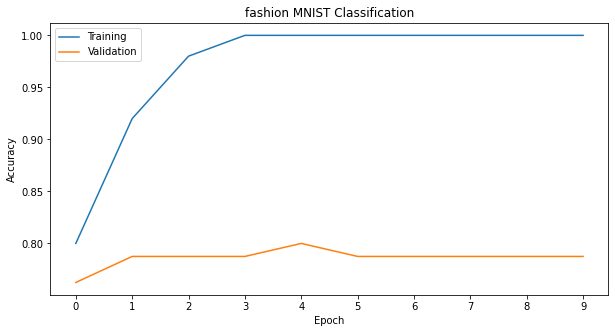

In [42]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.show()